# Notebook to make figures on Sentinel-1 NRB sample product

Comparison of Sentinel-1 RTC output for an area in Western Austria, with steep terrain and forest cover. 

Method used to produce the RTC and per-pixel metadata:
1. (option 1) Normalize to gamma0_rtc in GRD pixels for all pixels; for each output pixel, interpolate gamma0_rtc and scattering area image. Shadow mask in GRD is extended by 1 pixel using a MAX filter then interpolated with nearest neightbor resampling to output pixel.

The optimal RTC output should have:
1. Minimal artifacts near radar shadow. Inside and near the radar shadow, scattering area is either zero or a small value, so a small uncertainty in the scattering area leads to large uncertainty in gamma0_rtc. Any pixel that is potentially affected by this uncertainty should be masked out.
2. Consistent backscatter measured between ascending and descending passes. The images used in the comparison are taken one day apart, therefore no signifant land cover change is expected between the two passes.
3. For areas with uniform forest cover, gamma0_rtc should have minimal dependence on look angle.


In [41]:
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
import glob
import json
import os

import datacube
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#import DE Africa script
import sys
sys.path.append('../Scripts')
from deafrica_plotting import display_map

### Load S1 sample data

In [42]:
def load_s1_sample(s1_sample_path, band, time=None):
    fname = glob.glob(f"{s1_sample_path}/*{band}.tif")[0]
    if time:
        return xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000}).squeeze().to_dataset(name=band).expand_dims({'time':[time]})
    else:
        return xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000}).squeeze().to_dataset(name=band)

In [3]:
# figure for a different area

In [111]:
def load_s1_sample_combined(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/**/*_{band}.tif", recursive=True)
    data = []
    for fname in fnames:
        meta = fname.replace(f"_{band}.tif", "_metadata.json")
        date = np.datetime64(json.load(open(meta))["properties"]["datetime"][:13])
        # print(fname, date)
        data.append(
            xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000})
            .squeeze()
            .to_dataset(name=band)
            .expand_dims({"time": [date]})
        )
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype).sortby("time")

bands = ["VV", "VH", "MASK", "AREA", "ANGLE"]
s1_sample_path = "s1_sample/N05W001/2018/09/30"

data = [load_s1_sample_combined(s1_sample_path, band) for band in bands]
combined = xr.combine_by_coords(data).sortby('time')


lat, lon = (combined.y.values[0], combined.y.values[-1]), (combined.x.values[0], combined.x.values[-1])

lat, lon = (5.85, 5.5), (-0.4, -0.05)
y=slice(*lat)
x=slice(*lon)

combined_sub_1 = combined.sel(y=y, x=x).drop('band').compute()

# check area in map
display_map(x=lon, y=lat)

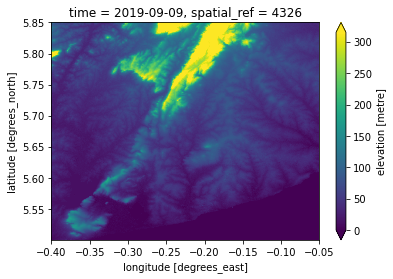

In [112]:
dc=datacube.Datacube()
dem = dc.load(product='srtm', lat=lat, lon=lon).squeeze()
dem.elevation.plot.imshow(robust=True);

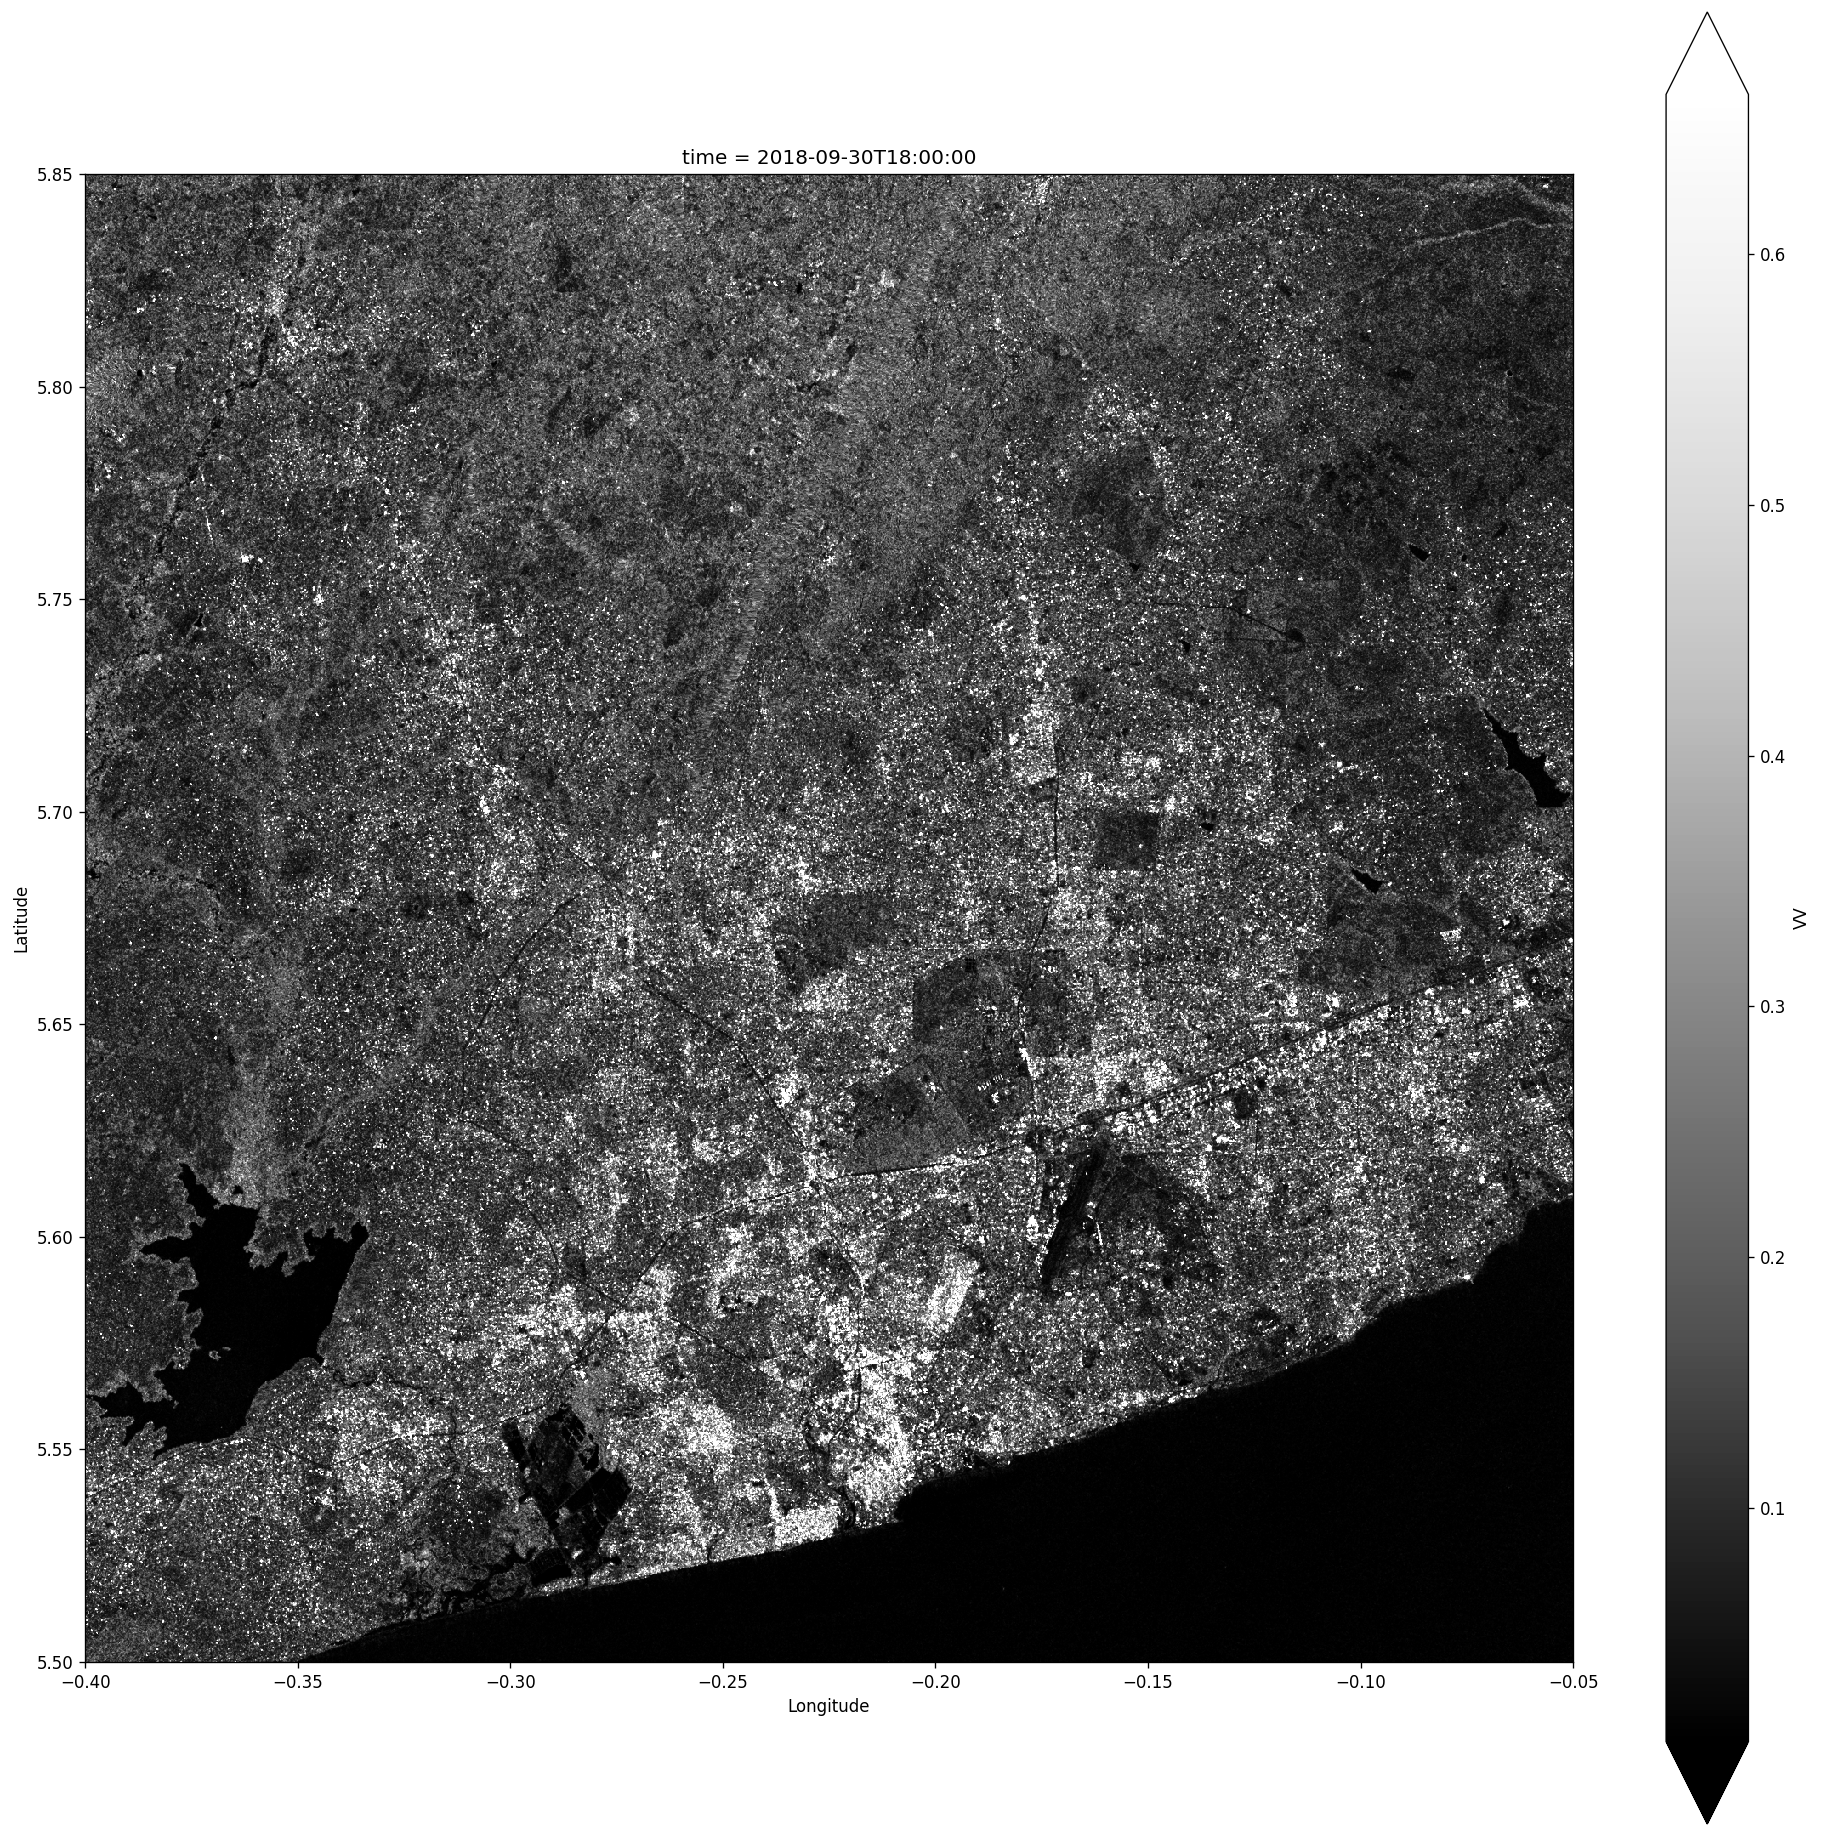

In [114]:
dpi=120
itime=0
band ='VV'
title= 'VV'
vrange = None
fig=plt.figure(dpi=dpi, figsize=(20,20))
ax = fig.add_subplot(111)
if 'VV' in band or 'VH' in band:
    da = combined_sub_1.isel(time=itime)[band].where(combined_sub_1.isel(time=itime).MASK==1)
else:
    da = combined_sub_1.isel(time=itime)[band]
#if vrange:
#    da.rename(title).rename({'x':'Longitude','y':'Latitude'}).plot.imshow(vmin=vrange[0], vmax=vrange[1], cmap='Greys')
#else:
da.rename(title).rename({'x':'Longitude','y':'Latitude'}).plot.imshow(robust=True, cmap='Greys_r')
ax.set_aspect('equal')
plt.savefig("%s.jpg"%(band.lower()), bbox_inches='tight');

In [102]:
# load data from option 1

bands = ["VV", "VH", "MASK", "AREA", "ANGLE"]
s1_sample_path = "s1_sample_austria/test_Austria_Descending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-06"
data = [load_s1_sample(s1_sample_path, band, time=np.datetime64('2020-07-06')) for band in bands]
s1_sample_path = "s1_sample_austria/test_Austria_Ascending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-07"
data += [load_s1_sample(s1_sample_path, band, time=np.datetime64('2020-07-07')) for band in bands]

combined_1 = xr.combine_by_coords(data)

In [103]:
# select area with terrain

lat, lon = (46.65,46.6),  (12.35,12.40) # steep but some rocky top

lat, lon = (46.3,46.2), (12.32,12.42) # steep, mostly forest cover

#lat, lon = (46.36,46.26), (12.82,12.92) # slightly flatter, mostly forest cover

#lat, lon = (46.26,46.16), (12.0,12.1) # steep, forest cover

y=slice(*lat)
x=slice(*lon)

combined_sub_1 = combined_1.sel(y=y, x=x).drop('band').compute()
combined_sub_1["VV_db"] = 10 * np.log10(combined_sub_1["VV"])
combined_sub_1["VH_db"] = 10 * np.log10(combined_sub_1["VH"])

In [104]:
# check area in map

display_map(x=lon, y=lat)
#display_map(x=(12, 13), y=(47, 46))

In [105]:
from datacube.utils.geometry import GeoBox, box, CRS
import rioxarray
from odc.algo import xr_reproject

def load_from_cog(url, name=None, resampling = 'nearest', chunks = dict(x=10_000, y=10_000), **kwargs):
    output_grid = kwargs.get('geobox')
    if output_grid is None:
        try:
            x = kwargs['x']
            y = kwargs['y']
            resolution = kwargs['resolution']
            output_crs = kwargs['output_crs']
            input_crs = kwargs.get('crs', 'EPSG:4326')
        except KeyError:
            print("x, y, resolution and output_crs are required if geobox is not supplied.")
            return
        # define output geometry
        gbox = box(x[0], y[0], x[1], y[1], crs = input_crs)
        # define output bounding box
        output_gbox = gbox.to_crs(crs=CRS(output_crs))
        # define output grid
        output_grid = GeoBox.from_geopolygon(output_gbox, resolution = resolution)

    img_all = rioxarray.open_rasterio(url, chunks=chunks).squeeze('band')
    if name is None: name = url.split('/')[-1].split('.')[0]
    img_all.name = name 
    return xr_reproject(img_all, output_grid, resampling=resampling).compute()

#url = 'https://deafrica-data.s3-us-west-2.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif'


In [7]:
# vegetation index
#veg_1 = 4 * combined_sub_1.VH / (combined_sub_1.VH + combined_sub_1.VV)

In [8]:
# super rough forest area estimate
#forest_1 = (veg_1 > 0.8) & (combined_sub_1.VV_db > -15) #& (srtm.elevation.values>800)

In [9]:
#forest_1.isel(time=0).plot.imshow(robust=True, figsize=(12,10));

## Figures for paper

In [10]:
dpi = 120
plt.rc('font', size=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

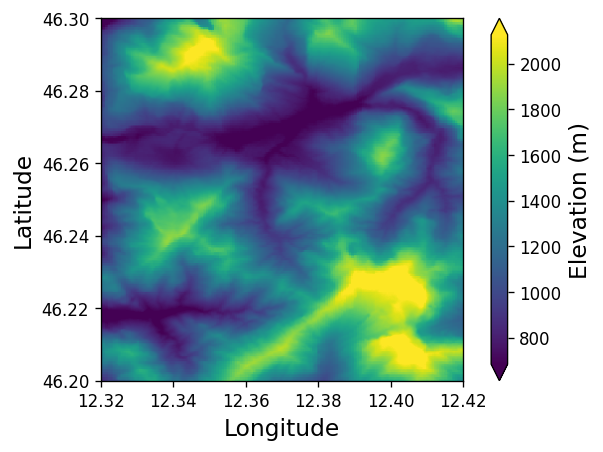

In [11]:
# Copernicus DEM

dem = load_from_cog('s1_sample_austria/Copernicus_DSM_COG_10_N46_00_E012_00_DEM.tif', x=lon, y=lat, resolution=(-0.0002, 0.0002), output_crs = 'EPSG:4326')
dem = dem.rename({"latitude": "Latitude", "longitude": "Longitude"}).rename('Elevation (m)').drop('spatial_ref')

del dem.Latitude.attrs['units']
del dem.Longitude.attrs['units']

fig=plt.figure(dpi=dpi)
ax = fig.add_subplot(111)
dem.plot.imshow(robust=True, ax=ax);
ax.set_aspect('equal')
plt.savefig("copernicus_dem.eps", bbox_inches='tight');

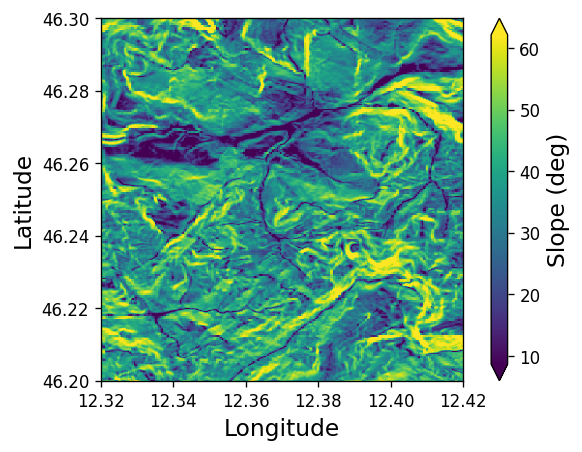

In [12]:
slope = load_from_cog('s1_sample_austria/dem_6933_slope_deg.tif', x=lon, y=lat, resolution=(-0.0002, 0.0002), output_crs = 'EPSG:4326')
slope = slope.rename({"latitude": "Latitude", "longitude": "Longitude"}).rename('Slope (deg)').drop('spatial_ref')

del slope.Latitude.attrs['units']
del slope.Longitude.attrs['units']

fig=plt.figure(dpi=dpi)
ax = fig.add_subplot(111)
slope.plot.imshow(robust=True, ax=ax);
ax.set_aspect('equal')
plt.savefig("copernicus_slope.eps", bbox_inches='tight');

In [13]:
for band in ['VV', 'VH', 'VV_db', 'VH_db']:
    combined_sub_1[band] = combined_sub_1[band].where(combined_sub_1.MASK==1)

In [14]:
combined_sub_1.quantile([0.02,0.98]).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:   (quantile: 2)
Coordinates:
  * quantile  (quantile) float64 0.02 0.98
Data variables:
    ANGLE     (quantile) float64 7.0 94.0
    AREA      (quantile) float64 0.0 21.34
    MASK      (quantile) float64 1.0 2.0
    VH        (quantile) float64 0.005714 0.1403
    VV        (quantile) float64 0.02115 0.6297
    VV_db     (quantile) float64 -16.75 -2.008
    VH_db     (quantile) float64 -22.43 -8.529>

In [48]:
    
for band, title, vrange in zip(['ANGLE','AREA','VV', 'VH','VV_db', 'VH_db'], 
                                ['Local Incidence Angle (deg)', 'Scattering Area', 'VV', 'VH', 'VV (dB)', 'VH (dB)'], 
                                [[10,90], None, [0.,0.6], [0.0, 0.14], [-16., -2], [-22, -8]]):

    for itime, orbit in zip([0,1], ['d', 'a']):

        fig=plt.figure(dpi=dpi)
        ax = fig.add_subplot(111)
        if 'VV' in band or 'VH' in band:
            da = combined_sub_1.isel(time=itime)[band].where(combined_sub_1.isel(time=itime).MASK==1)
        else:
            da = combined_sub_1.isel(time=itime)[band]
        if vrange:
            da.rename(title).rename({'x':'Longitude','y':'Latitude'}).plot.imshow(vmin=vrange[0], vmax=vrange[1])
        else:
            da.rename(title).rename({'x':'Longitude','y':'Latitude'}).plot.imshow(robust=True)
        ax.set_aspect('equal')
        plt.savefig("%s_%s.jpg"%(band.lower(), orbit), bbox_inches='tight');

NameError: name 'dpi' is not defined

In [16]:
diff_1_db = (combined_sub_1.isel(time=0)-combined_sub_1.isel(time=1))[['VV_db', 'VH_db']].where(combined_sub_1.MASK.isel(time=0)==1).where(combined_sub_1.MASK.isel(time=1)==1)
print('mean and std of difference VV between passes:', diff_1_db.VV_db.mean().values, diff_1_db.VV_db.std().values)
print('mean and std of difference VH between passes:', diff_1_db.VH_db.mean().values, diff_1_db.VH_db.std().values)

mean and std of difference VV between passes: 0.08836201 4.135282516479492
mean and std of difference VH between passes: 0.09135283 3.9256832599639893


In [17]:
diff_1 = (combined_sub_1.isel(time=0)-combined_sub_1.isel(time=1))[['VV', 'VH']].where(combined_sub_1.MASK.isel(time=0)==1).where(combined_sub_1.MASK.isel(time=1)==1)
#diff_1 = diff_1.where(combined_sub_1.AREA.isel(time=0)>0.5).where(combined_sub_1.AREA.isel(time=1)>0.5)
#diff_1.VV.plot.imshow(figsize=(12,10), robust=True, vmin=-0.2, vmax=0.2);
print('mean and std of difference VV between passes:', diff_1.VV.mean().values, diff_1.VV.std().values)
print('mean and std of difference VH between passes:', diff_1.VH.mean().values, diff_1.VH.std().values)

mean and std of difference VV between passes: 0.0052475813 0.40594735741615295
mean and std of difference VH between passes: 0.0017034947 0.08129381388425827


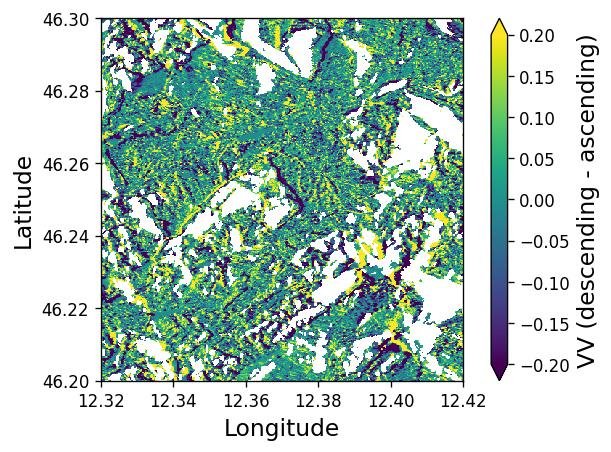

In [18]:
fig=plt.figure(dpi=dpi)
ax = fig.add_subplot(111)
diff_1.VV.rename('VV (descending - ascending)').rename({'x':'Longitude','y':'Latitude'}).plot.imshow(vmin=-0.2,vmax=0.2)
ax.set_aspect('equal')
plt.savefig("diff_VV.eps", bbox_inches='tight');

In [19]:
def plot_linear(arr1, arr2, band, xedges = list(np.arange(0, 90, 1)), yedges = list(np.arange(-15, 0, 0.01))):
    valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
    arr1, arr2 = arr1[valid], arr2[valid]
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(arr1[:, np.newaxis], arr2[:, np.newaxis])
    ## The coefficients
    print(
        "Band:{0}, slope={1}, intercept={2}, r2={3}".format(
        band,
        regr.coef_[0][0],
        regr.intercept_[0],
        regr.score(arr1[:, np.newaxis], arr2[:, np.newaxis]),
        )
    )

    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    cmname = "YlGnBu"
    cmname = "rainbow"
    hist, xe, ye = np.histogram2d(arr2, arr1, bins=(yedges, xedges))
    plt.pcolor(X, Y, hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()));
    c=plt.colorbar();
    c.set_label('Number of pixels')
    #plt.contour(X, Y, np.log10(hist), cmap=cmname, levels=5);
    #plt.plot(xedges, regr.predict(np.array(xedges)[:, np.newaxis]), ":");
    plt.xlim((xedges[0],xedges[-1]))
    plt.ylim((yedges[0],yedges[-1]))
    plt.xlabel('Local incidenc angle');
    plt.ylabel(band);

Band:VV_db, slope=-0.004862961359322071, intercept=-7.924922943115234, r2=0.0013503853009606548


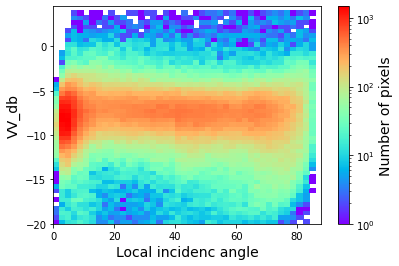

In [20]:
band = "VV_db"

arr1 = (np.arctan(1/combined_sub_1.AREA.isel(time=0))*180./np.pi).where(combined_sub_1.MASK.isel(time=0)==1).values.flatten()
arr2 = combined_sub_1[band].isel(time=0).where(combined_sub_1.MASK.isel(time=0)==1).values.flatten()
plot_linear(arr1, arr2, band, xedges = list(np.arange(0, 90, 2)), yedges = list(np.arange(-20, 5, 0.5)))

Band:VV_db, slope=0.005960114765912294, intercept=-8.447607040405273, r2=0.0018599521394904173


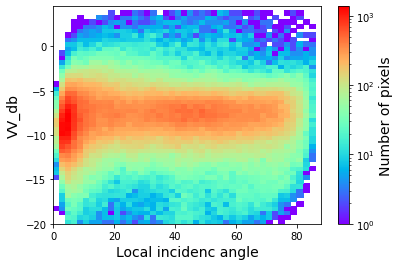

In [21]:
band = "VV_db"

arr1 = (np.arctan(1/combined_sub_1.AREA.isel(time=1))*180./np.pi).where(combined_sub_1.MASK.isel(time=1)==1).values.flatten()
arr2 = combined_sub_1[band].isel(time=1).where(combined_sub_1.MASK.isel(time=1)==1).values.flatten()
plot_linear(arr1, arr2, band, xedges = list(np.arange(0, 90, 2)), yedges = list(np.arange(-20, 5, 0.5)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


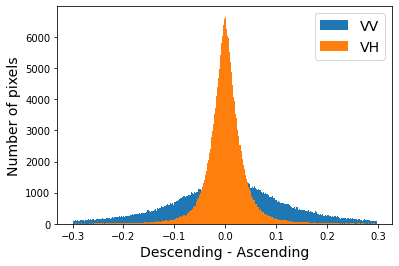

In [22]:
diff_1.VV.plot.hist(bins=np.arange(-0.3, 0.3, 0.002), figsize=(6,4), label='VV');
diff_1.VH.plot.hist(bins=np.arange(-0.3, 0.3, 0.002), label='VH');
plt.xlabel('Descending - Ascending');
plt.ylabel('Number of pixels');
plt.title('');
plt.legend();
plt.savefig("diff_hist.eps", bbox_inches='tight');

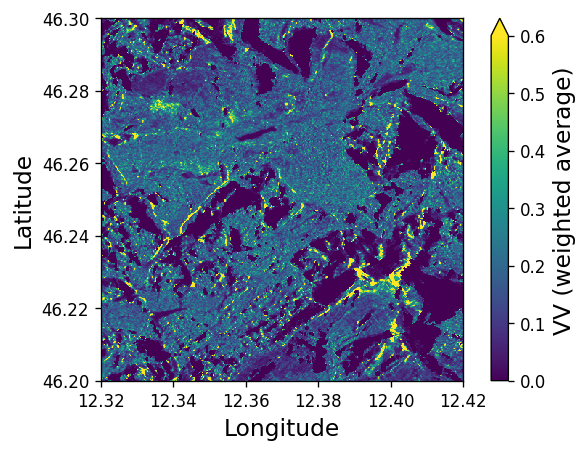

In [23]:
### Loal Resolution Weighting
weight_1 = 1/combined_sub_1.AREA
combined_sub_1_vv = (combined_sub_1.VV.where(combined_sub_1.MASK==1)*weight_1).sum('time')/weight_1.sum('time')

fig=plt.figure(dpi=dpi)
ax = fig.add_subplot(111)
combined_sub_1_vv.rename('VV (weighted average)').rename({'x':'Longitude','y':'Latitude'}).plot.imshow(vmin=0, vmax=0.6)
ax.set_aspect('equal')
plt.savefig("LRW_VV.eps", bbox_inches='tight');

In [24]:
combined_sub_1_vv

<xarray.DataArray (y: 500, x: 500)>
array([[0.15382735, 0.08399193, 0.06729865, ..., 0.27224517, 0.17416167,
        0.07443915],
       [0.10100453, 0.09908701, 0.05141735, ..., 0.39745176, 0.32075602,
        0.12104455],
       [0.07949524, 0.10086276, 0.05857006, ..., 0.49665907, 0.3319338 ,
        0.21385191],
       ...,
       [0.16790247, 0.2230795 , 0.20601423, ..., 0.10012174, 0.11399358,
        0.16599986],
       [0.12731187, 0.06751284, 0.05971907, ..., 0.09821414, 0.08850382,
        0.10439748],
       [0.23917548, 0.2689208 , 0.06245485, ..., 0.13945223, 0.0952993 ,
        0.07884151]], dtype=float32)
Coordinates:
  * y        (y) float64 46.3 46.3 46.3 46.3 46.3 ... 46.2 46.2 46.2 46.2 46.2
  * x        (x) float64 12.32 12.32 12.32 12.32 ... 12.42 12.42 12.42 12.42